# Findings

Need to account for public holidays. October 24th (Labour day) had abnormally low numbers with good weather.

- Tried categorising lambda on the day of the week. Found the days are actually somewhat different, so this is useful. Though it may be a good idea to do this via a multi-level model. Might need to split weekday and weekend if I do.

- Could try also categorising lambda on the location. Almost certainly want to use a multi-level model for that since we expect locations to show similar behaviour.

I think for this notebook, its probably enough to do the multi-level model for lambda based on day-of-week. After this, we should try to figure out how to get time data included. Probably involves gaussian process.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import polars as pl
import numpy as np
import scipy

import pymc as pm
import arviz as az

import warnings

warnings.filterwarnings("ignore")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
data = pl.read_parquet("../data/counter_data.parquet").with_columns(pl.col("weekday") - 1)

In [3]:
filtered_data = data.filter(
    (pl.col("year") == 2022) & 
    (pl.col("site_name") == "Thorndon Quay") &
    (pl.col("hour") == 8)
)

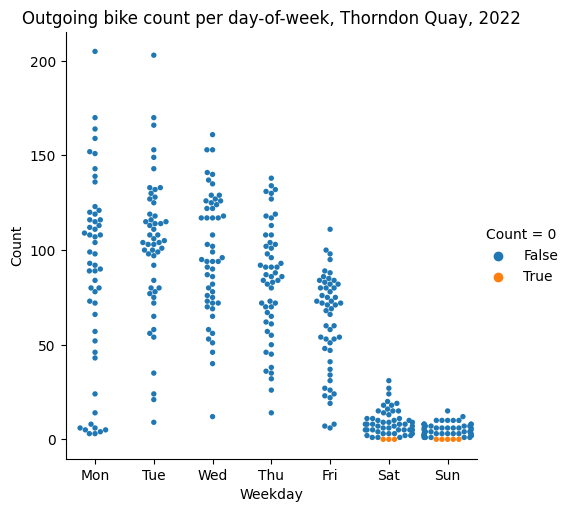

In [4]:
sns.catplot(
    filtered_data.with_columns(
        pl.col("weekday").map_dict({0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}),
        pl.col("count_outgoing").cast(float),
        (pl.col("count_outgoing") == 0).alias("Count = 0")
    ).to_pandas(), 
    x="weekday", 
    y="count_outgoing", 
    hue="Count = 0", 
    s=15, 
    kind="swarm", 
    order="Mon,Tue,Wed,Thu,Fri,Sat,Sun".split(",")
)
plt.ylabel("Count")
plt.xlabel("Weekday")
plt.title("Outgoing bike count per day-of-week, Thorndon Quay, 2022");

Model describes bike count $c_i$ as GammaPoisson distribution conditional on day of the week, for data sampled where: 

- location = "Thorndon Quay"
- year = 2022
- time = 8am - 9am
- direction = "Outgoing"

$weekday[i]$ is indexed day of week for sample $i$, with Monday = 0. 

$is\_weekend[i]$ is 0 if weekday index $i$ is in Monday - Friday, and 1 if $i$ is in Saturday - Sunday. 

\begin{align}
c_i &\sim GammaPoisson(\phi, \mu_{weekday[i]}) \\
\mu_{j = 0..6} &\sim Gamma(\alpha_{is\_weekday[j]}, \beta_{is\_weekday[j]}) \\
\alpha_{0..1} &\sim HalfNormal(2.5) \\
\beta_{0..1} &\sim Exponential(1) \\
\phi &\sim Exponential(1)
\end{align}

In [5]:
with pm.Model() as m_1:
    weekday = pm.MutableData("weekday", np.array(filtered_data["weekday"]), dims="obs_id")
    
    alpha = pm.HalfNormal("alpha", sigma=2.5, shape=2)
    beta = pm.Exponential("beta", scale=1, shape=2)
    
    is_weekend = (np.arange(7) >= 5).astype(int)
    mu = pm.Gamma("mu", alpha=alpha[is_weekend], beta=beta[is_weekend])
    phi = pm.Exponential("phi", scale=1)
    
    # c = pm.Poisson("c", lmda[weekday], observed=np.array(filtered_data["count_outgoing"]), dims="obs_id")
    c = pm.NegativeBinomial("c", alpha=phi, mu=mu[weekday], observed=np.array(filtered_data["count_outgoing"]), dims="obs_id")
    
    # m_1.debug()
    trace = pm.sample_prior_predictive(1000)
    trace.extend(pm.sample(3000, tune=3000))
    trace.extend(pm.sample_posterior_predictive(trace))
    

Sampling: [alpha, beta, c, mu, phi]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, mu, phi]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 7 seconds.
Sampling: [c]


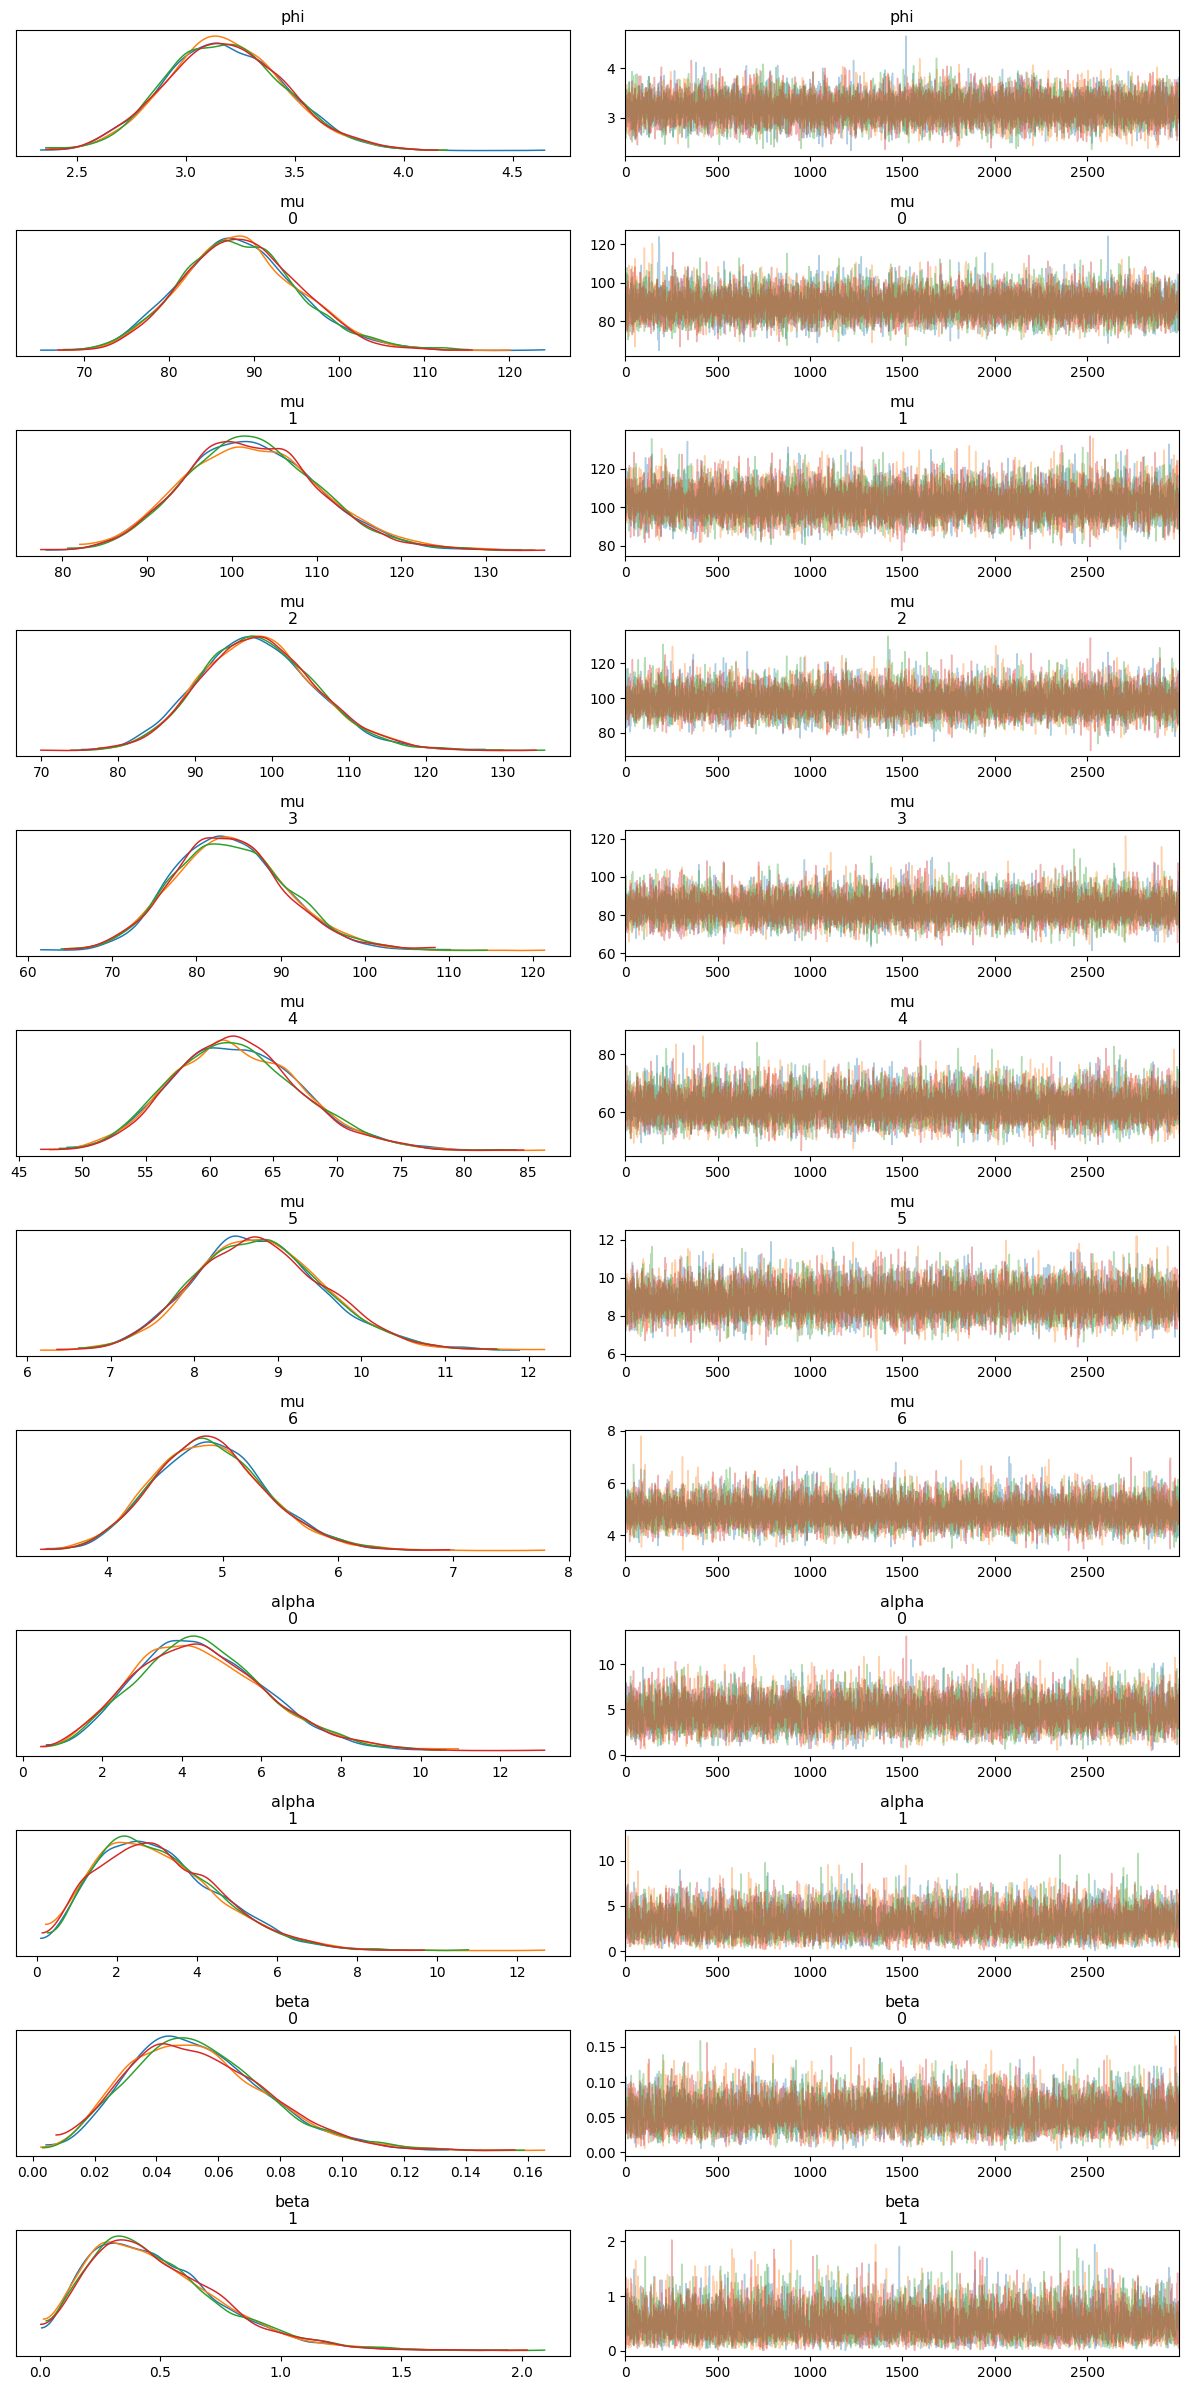

In [6]:
az.plot_trace(trace, compact=False, var_names=["phi", "mu", "alpha", "beta"]);
plt.tight_layout()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

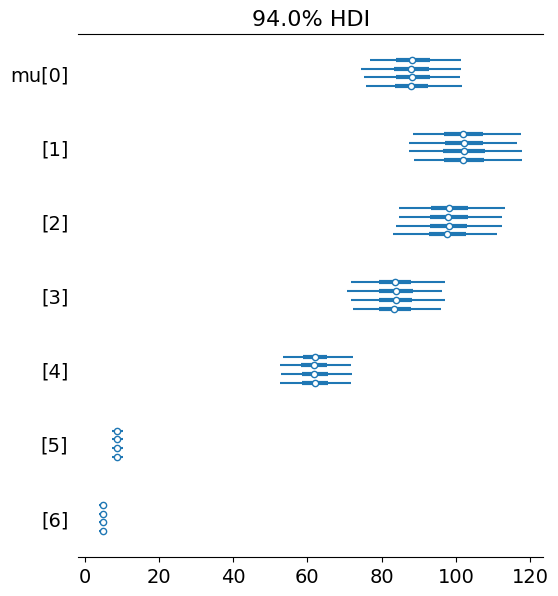

In [7]:
az.plot_forest(trace, var_names=["mu"])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

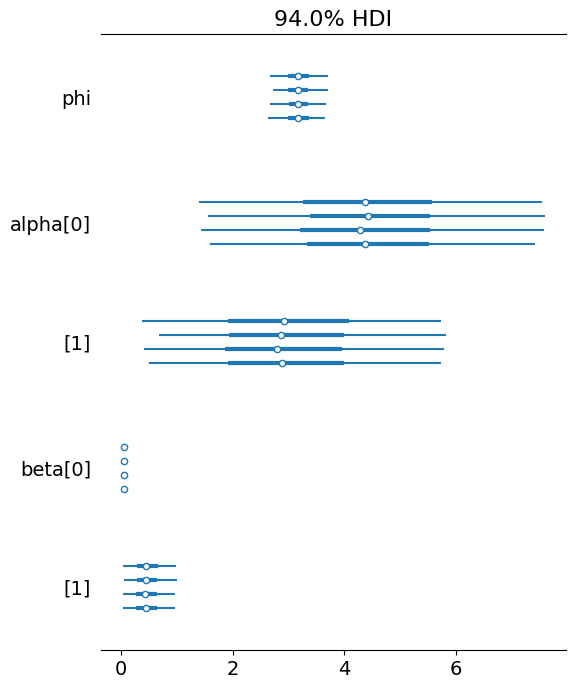

In [8]:
az.plot_forest(trace, var_names=["phi", "alpha", "beta"])

In [9]:
compare_df = (
    filtered_data.with_columns(
        pl.Series(
            name="post_preds", 
            values=az.extract(trace.posterior_predictive)["c"][:,0].to_numpy())
    ).melt(
        id_vars="weekday", 
        value_vars=["count_outgoing", "post_preds"]
    ).with_columns(
        pl.col("variable").map_dict(
            {"count_outgoing": "Observation", "post_preds": "Posterior Prediction"}
        )
    )
)
compare_df.columns = ["Weekday", "Type", "Count"]

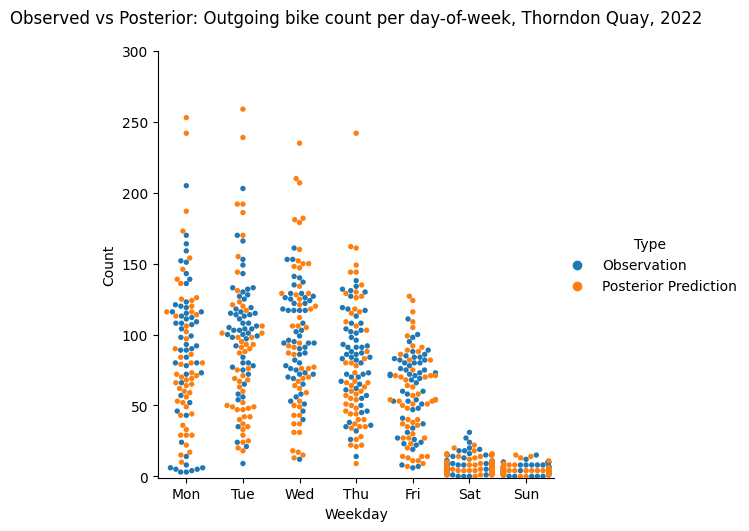

In [10]:
sns.catplot(
    compare_df.with_columns(
        pl.col("Weekday").map_dict({0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}),
        # pl.col("Count").cast(float),
        # (pl.col("Count") == 0).alias("Count = 0")
    ).to_pandas(), 
    x="Weekday", 
    y="Count", 
    hue="Type", 
    s=15, 
    kind="swarm", 
    order="Mon,Tue,Wed,Thu,Fri,Sat,Sun".split(",")
)
plt.ylabel("Count")
plt.xlabel("Weekday")
plt.ylim(-1,300)
plt.title("Observed vs Posterior: Outgoing bike count per day-of-week, Thorndon Quay, 2022", pad=20);